# Covid 19 example

In [1]:
import requests
import io
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/SanderSondeland/Master/main/corona_data_new.csv?token=GHSAT0AAAAAACBRT5KRZAWZGFMMNZ3Y5IBAZEIELWA'
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep='\t')
data

,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED
0,Afghanistan,2020-02-24 23:59:00,0,1,0,0
1,Afghanistan,2020-02-25 23:59:00,1,1,0,0
2,Afghanistan,2020-02-26 23:59:00,2,1,0,0
3,Afghanistan,2020-02-27 23:59:00,3,1,0,0
4,Afghanistan,2020-02-28 23:59:00,4,1,0,0
...,...,...,...,...,...,...
44516,Hubei,2020-10-21 23:59:00,273,68139,4512,63627
44517,Hubei,2020-10-22 23:59:00,274,68139,4512,63627
44518,Hubei,2020-10-23 23:59:00,275,68139,4512,63627
44519,Hubei,2020-10-24 23:59:00,276,68139,4512,63627


In [3]:
data_A = data[data['LOCATION'] == 'Afghanistan']
data_A

,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED
0,Afghanistan,2020-02-24 23:59:00,0,1,0,0
1,Afghanistan,2020-02-25 23:59:00,1,1,0,0
2,Afghanistan,2020-02-26 23:59:00,2,1,0,0
3,Afghanistan,2020-02-27 23:59:00,3,1,0,0
4,Afghanistan,2020-02-28 23:59:00,4,1,0,0
...,...,...,...,...,...,...
240,Afghanistan,2020-10-21 23:59:00,240,40510,1501,33824
241,Afghanistan,2020-10-22 23:59:00,241,40626,1505,33831
242,Afghanistan,2020-10-23 23:59:00,242,40687,1507,34010
243,Afghanistan,2020-10-24 23:59:00,243,40768,1511,34023


In [4]:
time_A = data_A['ELAPSED_TIME_SINCE_OUTBREAK'].to_numpy()
confirmed_A = data_A['CONFIRMED'].to_numpy()
confirmed_A = confirmed_A[35:]
time_A = time_A[35:]

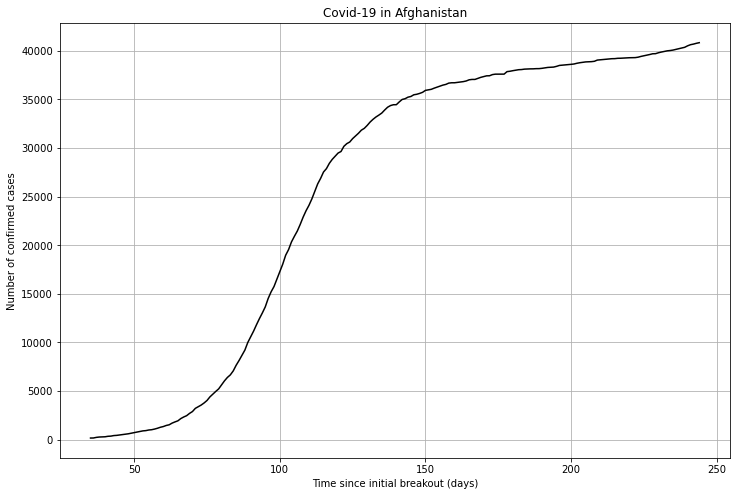

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
plt.title('Covid-19 in Afghanistan')
plt.xlabel('Time since initial breakout (days)')
plt.ylabel('Number of confirmed cases')
ax.plot(time_A, confirmed_A, color='black')

plt.show()

# SINDy method 

In [7]:
from scipy.integrate import solve_ivp
from derivative import dxdt

In [8]:
def create_library(u: np.ndarray, polynomial_order: int,
                   use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.
    For example, if our u depends on x, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, x^2.
    """
    
    u = u.reshape((-1, 1))
    
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta

In [10]:
def calculate_regression(theta: np.ndarray, uprime: np.ndarray, threshold: float, max_iterations: int) -> np.ndarray:
    # Solve theta * xi = uprime in the least-squares sense.
    xi = np.linalg.lstsq(theta, uprime, rcond=None)[0]
    xi_before = xi
    n = len(xi)
    #print('xi before sparisty: ', xi)

    # Add sparsity.
    for _ in range(max_iterations):
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
        for j in range(n):
            big_indices = np.logical_not(small_indices)
            xi[big_indices] = np.linalg.lstsq(theta[:, big_indices],
                                              uprime,
                                              rcond=None)[0]

    return xi_before, xi 

In [11]:
def approximation(_: float, u: np.ndarray, xi: np.ndarray) -> np.ndarray:
    theta = create_library(u.reshape((1, 3)), POLYNOMIAL_ORDER, USE_TRIG)
    return theta @ xi

def compute_trajectory(u0: np.ndarray, xi: np.ndarray) -> np.ndarray:
    if u0.size == 1:
        u0 = np.repeat(u0, 3)
    else:
        u0 = u0.reshape((3,))
    t0 = 0
    dt = 1
    tmax = 210
    n = int(tmax / dt + 1)

    t = np.linspace(start=t0, stop=tmax, num=n)
    result = solve_ivp(fun=approximation,
                       t_span=(t0, tmax),
                       y0=u0,
                       t_eval=t,
                       args=(xi, ))
    u = result.y.T

    return u

In [12]:
data_A_der = dxdt(confirmed_A, time_A, kind="kalman", alpha=2)

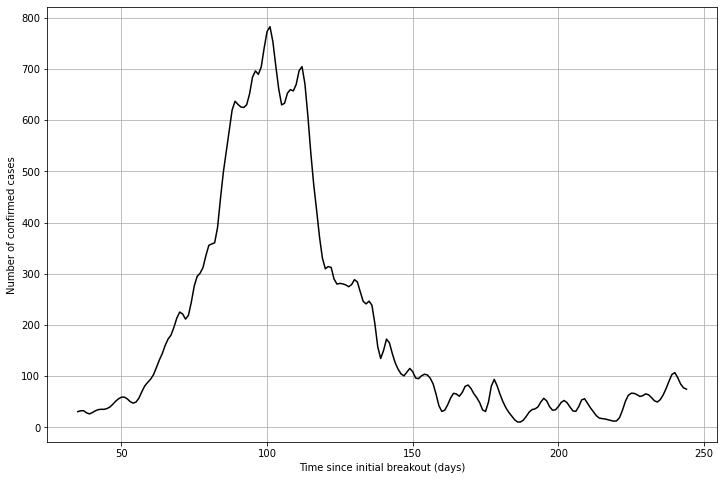

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.set_xlabel('Time since initial breakout (days)')
ax.set_ylabel('Number of confirmed cases')
ax.plot(time_A, data_A_der, color='black')

In [14]:
POLYNOMIAL_ORDER = 3
USE_TRIG = False
USE_EXP = False
T_ORDER = 1

theta = create_library(confirmed_A, POLYNOMIAL_ORDER, USE_TRIG)

In [25]:
THRESHOLD = 0.000001
MAX_ITERATIONS = 10

xi_before, xi = calculate_regression(theta, data_A_der, THRESHOLD, MAX_ITERATIONS)

mat_0 = confirmed_A[0]
u_approximation = compute_trajectory(mat_0, xi)
xi


(4,)


array([ 4.74599839e+01,  6.02929056e-02, -1.57168749e-06,  0.00000000e+00])

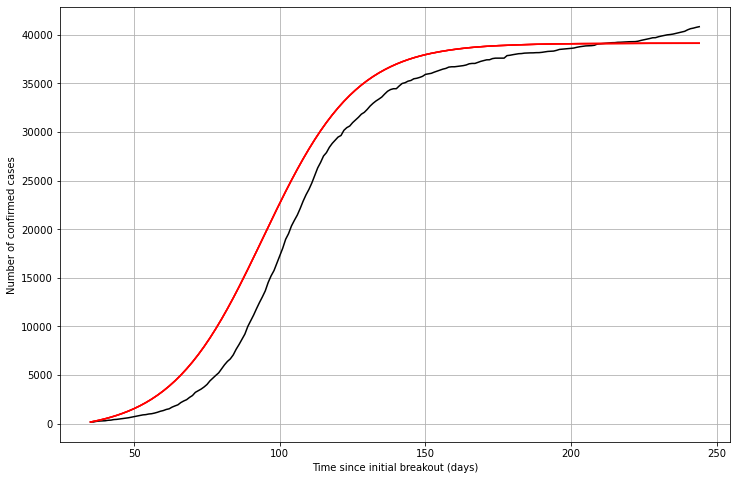

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.set_xlabel('Time since initial breakout (days)')
ax.set_ylabel('Number of confirmed cases')
ax.plot(time_A, confirmed_A, color='black')
ax.plot(time_A, u_approximation[:-1], color='red')